In [1]:
import bnlearn as bn
import os
import typing
import pandas as pd
import matplotlib.pyplot as plt
from collections import namedtuple
from pgmpy.models import DynamicBayesianNetwork as DBN
from pgmpy.inference import DBNInference
from pgmpy.factors.discrete import TabularCPD
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, mean_squared_error, mean_absolute_error
import numpy as np
from copy import deepcopy
from sklearn.preprocessing import LabelEncoder, QuantileTransformer

In [2]:
valid_patients = pd.read_json('/home/nmramorov/Downloads/Telegram Desktop/patients_covid_preumonia.json', orient='values')
valid_patients[0]

0       GACAmLq
1       GACAlщU
2       GACA^ov
3       GACAk(t
4       GACAm`Г
         ...   
2209    GACAlшG
2210    GACAk/O
2211    GACAjцy
2212    GACAjюС
2213    GACASух
Name: 0, Length: 2214, dtype: object

In [3]:

"""
Применим биннинг, предварительно нормализовав данные
"""
def binning(x: pd.Series, thresh: int = 3) -> typing.Union[typing.List, pd.Series]:
    label_encoder = LabelEncoder()
    quantile_transformer = QuantileTransformer(n_quantiles=thresh, output_distribution='normal')
    
    if len(x.unique()) > thresh:
        x_norm = quantile_transformer.fit_transform(x.to_numpy().reshape((-1, 1)))
        return label_encoder.fit_transform(pd.cut(x_norm.reshape(1, -1)[0], thresh, retbins=True)[0])
    else:
        return x

In [4]:
def get_significant_features(df: pd.DataFrame, target: str, corr_thresh: int = 0.2) -> typing.List:

    corrs = df.corr()[target]
    #Отфильтруем фичи: возьмем с позитивной корреляцией, так как они оказывают прямое
    #влияние на target
    req_corrs = corrs[(corrs > corr_thresh) & (corrs != 1)]
    
    corrs_sorted = pd.DataFrame(req_corrs).sort_values(
        by=target
    )

    print(f'Число фич: {len(req_corrs)}')
    significant_columns = corrs_sorted.index.to_list()
    
    return significant_columns


In [5]:
def preprocess_df(path_to_dataframe: str, target: str, corr_thresh: int) -> pd.DataFrame:
    df = pd.read_csv(path_to_dataframe, index_col=0)
    df.dropna(axis=1, thresh=df.shape[0] // 1.5, inplace=True)
    df.fillna(df.mean().astype(int, errors='ignore').apply(
    lambda x: np.round_(x)), inplace=True)
    
    df = df.apply(lambda x: binning(x))
    
    significant_features = get_significant_features(df, target, corr_thresh)
    df = df[significant_features + [target]]
    
    return df
    

In [6]:
graph_store_type = namedtuple('Graph', 'graph model parameter_model filename')

In [7]:
import networkx as nx
import matplotlib.pyplot as plt


def create_fancy_model_graph(model, feature, layout=nx.random_layout, arrow_size=20, font_size=6, ax=None, label=None):
    bayesian_edges = list(model['model_edges'])

    G = nx.DiGraph()
    G.add_edges_from(bayesian_edges)
            
    pos = nx.circular_layout(G)
        
    nx.draw_networkx(G=G,
                    arrows=True,
                    pos=pos,
                    arrowsize=10,
                    font_size=font_size,
                    ax=ax)
    return G


def save_bayesian_network(df: pd.DataFrame,
                            model,
                            model_with_params,
                            model_name: str,
                            feature: str) -> namedtuple:

    G = create_fancy_model_graph(model, feature)
    
    new_graph = graph_store_type(model=model,
                                parameter_model=model_with_params,
                                graph=G,
                                filename=f'{model_name}_bayes.dot')

    nx.write_edgelist(new_graph.graph, f'graphs/{model_name}_wrong_hillclimb_k2_bayes.csv', data=True, delimiter=',')
    
    return new_graph

In [8]:
def create_edges_for_DBN(edges: typing.List) -> typing.List:
    result = []
    
    for fst_node, snd_node in edges:
        result.append(((fst_node, 0), (snd_node, 0)))
        result.append(((fst_node, 1), (snd_node, 1)))

    return list(set(result))
    

In [9]:
def write_adjmat_for_gephi(edges: typing.List, target: str) -> int:
    with open(f'graphs/{target}.csv', 'w') as f:
        f.write('node1;node2\n')
        for fst, snd in edges:
            f.write(f'{fst};{snd}\n')
            
    return 0

In [10]:
features_to_translate = {
    'PCT- Тромбокрит_1': 'PCT_1',
    'PCT- Тромбокрит_0': 'PCT_0',
    'MPV- Средн.объем тромбоцитов_1': 'MPV_1',
    'MPV- Средн.объем тромбоцитов_0': 'MPV_0',
    'outcome_1': 'outcome_1',
    'HCT- Гематокрит_0': 'HCT_0',
    'HCT- Гематокрит_1': 'HCT_1',
    'MCHC- Ср.конц.Hg в эритроц._0': 'MCHC_0', 
    'MCHC- Ср.конц.Hg в эритроц._1': 'MCHC_1', 
    'АСТ_0': 'Aspartateaminotransferase_0',
    'АСТ_1': 'Aspartateaminotransferase_1',
    'gender_0': 'gender_0',
    'Вес_0': 'weight_0',
    'Лимфоциты%_0': 'lymphocytes%_0',
    'Лимфоциты%_1': 'lymphocytes%_1',
    'age_0': 'age_0',
    'Базофилы#_0': 'basophils#_0',
    'Базофилы#_1': 'basophils#_1',
    'Эозинофилы%_0': 'eosinophils%_0',
    'Эозинофилы%_1': 'eosinophils%_1',
    'aggregated_RDW_0': 'aggregated_RDW_0',
    'Общий белок_0': 'total_protein_0',
    'Общий белок_1': 'total_protein_1',
    'Рост_0': 'height_0',
    'ОАМ Глюкоза_0': 'urine_glucose_test_0',
    'Состояние_пациента_0': 'patient_condition_0', 
    'Состояние_пациента_1': 'patient_condition_1', 
    'cad_0': 'cad_0',
    'P-LCR- Отнош.крупных тр. к общ.кол-ву_0': 'P-LCR_0', 
    'ЧДД_0': 'respiratory_rate_0',
    'ЧДД_1': 'respiratory_rate_1',
    'ЧСС_0': 'heart_rate_0',
    'ЧСС_1': 'heart_rate_1',
    'Площадь поверхности тела_0': 'body surface area_0',
    'MPV- Средн.объем тромбоцитов_0': 'MPV_0', 
    'PLT- Тромбоциты_0': 'PLT_0',
    'PLT- Тромбоциты_1': 'PLT_1',
    'RBC- Эритроциты_0': 'RBC_0',
    'RBC- Эритроциты_1': 'RBC_1',
    'Калий_0': 'potassium_0',
    'Калий_1': 'potassium_1',
    'WBC- Лейкоциты_1': 'WBC_1',
    'WBC- Лейкоциты_0': 'WBC_0',
    'aggregated_MCH_0': 'aggregated_MCH_0', 
    'АЛТ_0': 'Alanineaminotransferase_0',
    'АЛТ_1': 'Alanineaminotransferase_1', 
    'Нейтрофилы%_0': 'neutrophils%_0',
    'Нейтрофилы%_1': 'neutrophils%_1',
    'RDW-CV_0': 'RDW-CV_0', 
    'RDW-SD_0': 'RDW-SD_0',
    'Температура_0': 'temperature_0', 
    'Температура_1': 'temperature_1',
    'PDW- Индекс расп.по объему тр._0': 'PDW_0',
    'HGB- Гемоглобин_0': 'HGB_0',
    'HGB- Гемоглобин_1': 'HGB_1',
    'Базофилы%_1': 'basophils%_1', 
    'Базофилы%_0': 'basophils%_0', 
    'PCT- Тромбокрит_0': 'PCT_0',
    'Билирубин общий_0': 'bilirubin_total_0',
    'Билирубин общий_1': 'bilirubin_total_1',
    'MCV- Средн.объем эритроцитов_0': 'MCV_0',
    'MCV- Средн.объем эритроцитов_1': 'MCV_1',
    'Моноциты%_0': 'monocytes%_0',
    'Моноциты%_1': 'monocytes%_1', 
    'Незрелые гранулоциты (IG%)_0': 'IG_0',
    'Незрелые гранулоциты (IG%)_1': 'IG_1',
    'С-реактивный белок (СРБ) колич._0': 'c-reactive protein#_0',
    'С-реактивный белок (СРБ) колич._1': 'c-reactive protein#_1',
    'ОАМ Удельная плотность_0': 'urine_specific density_0',
    'ОАМ Удельная плотность_1': 'urine_specific density_1',
    'dad_0': 'dad_0',
    'dad_1': 'dad_1',
    'Креатинин_0': 'creatinine_0',
    'Креатинин_1': 'creatinine_1',
    'ОАМ Кислотность (прибор)_0': 'urine_acidity_0'
}

In [13]:
def preprocess_dfs(path_to_dataframes: typing.List, target: str, corr_thresh: int) -> pd.DataFrame:
    
    df0 = pd.read_csv(path_to_dataframes[0], index_col=0)
    df1 = pd.read_csv(path_to_dataframes[1], index_col=0)
    df0.rename(columns={column: column + '_0' for column in df0.columns}, inplace=True)
    df1.rename(columns={column: column + '_1' for column in df1.columns}, inplace=True)
    
    df = pd.concat([df0, df1], axis=1)
    df = df.loc[valid_patients[0]]

    df.fillna(df.mean().astype(int, errors='ignore').apply(
        lambda x: np.round_(x)), inplace=True)
    
    df = df.apply(lambda x: binning(x))
    
    compulsory_features = ['Температура_0',
                           'Температура_1',
                           'ЧСС_0',
                           'ЧСС_1',
                           'cad_0',
                           'cad_1',
                           'Состояние_пациента_0',
                           'Состояние_пациента_1',
                           'С-реактивный белок (СРБ) колич._0',
                           'С-реактивный белок (СРБ) колич._1',
                           'age_0',
                           'ЧДД_0',
                           'ЧДД_1',
                           'Билирубин общий_0',
                           'Билирубин общий_1',
                           'Общий белок_0',
                           'Общий белок_1',
                           'MPV- Средн.объем тромбоцитов_0',
                           'MPV- Средн.объем тромбоцитов_1',
                           'PCT- Тромбокрит_0',
                           'PCT- Тромбокрит_1',
                           'Лимфоциты%_0',
                           'Лимфоциты%_1'
                          ]
    
    significant_features = ['HCT- Гематокрит_0',
                            'HCT- Гематокрит_1',
                            'MCHC- Ср.конц.Hg в эритроц._0', 
                            'MCHC- Ср.конц.Hg в эритроц._1', 
                            'АСТ_0', 
                            'gender_0',
                            'Вес_0',
                            'Лимфоциты%_0',
                            'Лимфоциты%_1',
                            'age_0',
                            'Базофилы#_0',
                            'Базофилы#_1',
                            'Эозинофилы%_0',
                            'Эозинофилы%_1',
                            'aggregated_RDW_0',
                            'Общий белок_0',
                            'Общий белок_1',
                            'Рост_0',
                            'ОАМ Глюкоза_0',
                            'MCH- Ср.содерж.Hb в 1 эритроците_0',
                            'Состояние_пациента_0', 
                            'Состояние_пациента_1', 
                            'cad_0',
                            'P-LCR- Отнош.крупных тр. к общ.кол-ву_0', 
                            'ЧДД_0',
                            'ЧДД_1',
                            'ЧСС_0',
                            'ЧСС_1',
                            'Площадь поверхности тела_0',
                            'MPV- Средн.объем тромбоцитов_0', 
                            'PLT- Тромбоциты_0',
                            'PLT- Тромбоциты_1',
                            'RBC- Эритроциты_0',
                            'RBC- Эритроциты_1',
                            'Калий_0',
                            'Калий_1',
                            'WBC- Лейкоциты_1',
                            'WBC- Лейкоциты_0',
                            'aggregated_MCH_0', 
                            'АЛТ_0',
                            'АЛТ_1', 
                            'Нейтрофилы%_0',
                            'Нейтрофилы%_1',
                            'Эозинофилы#_0',
                            'Эозинофилы#_1',
                            'RDW-CV_0', 
                            'RDW-SD_0',
                            'Температура_0', 
                            'Температура_1',
                            'PDW- Индекс расп.по объему тр._0',
                            'HGB- Гемоглобин_0',
                            'HGB- Гемоглобин_1',
                            'Базофилы%_1', 
                            'Базофилы%_0', 
                            'PCT- Тромбокрит_0',
                            'Билирубин общий_0',
                            'Билирубин общий_1',
                            'MCV- Средн.объем эритроцитов_0',
                            'MCV- Средн.объем эритроцитов_1',
                            'Моноциты%_0',
                            'Моноциты%_1', 
                            'Незрелые гранулоциты (IG%)_0',
                            'Незрелые гранулоциты (IG%)_1',
                            'С-реактивный белок (СРБ) колич._0',
                            'С-реактивный белок (СРБ) колич._1',
                            'ОАМ Удельная плотность_0',
                            'ОАМ Удельная плотность_1',
                            'dad_0',
                            'dad_1',
                            'Креатинин_0',
                            'Креатинин_1',
                            'ОАМ Кислотность (прибор)_0']

    significant_features = [feature for feature in significant_features if feature in df.columns]

    features = list(set(significant_features) - set(compulsory_features))
    corrs = df.corr().loc[features, target + '_1']
    #Отфильтруем фичи: возьмем с позитивной корреляцией, так как они оказывают прямое
    #влияние на target
    
    #### 
    # duration_treatment 0.028
    # result 0.035
    req_corrs = corrs[(corrs > 0) & (corrs != 1)] # ТЮНИТЬ ПАРАМЕТР ЗДЕСЬ (E.G corr > 0.01 etc)
    
    corrs_sorted = pd.DataFrame(req_corrs).sort_values(
        by=target + '_1'
    )

    sorted_features = corrs_sorted.index.to_list()
    
    final_features = compulsory_features[:16]
    print(f'Число фич: {len(final_features) + 1}')
    
    df = df[final_features + [target + '_1']].rename(columns=features_to_translate)

    X_train, X_test, y_train, y_test = train_test_split(df,
                                                        df[target + '_1'], 
                                                        test_size=0.2)
    
    X_test.drop(columns=target + '_1', inplace=True)
    
    return X_train, X_test, y_test

In [14]:
def prepare_cpds_for_DBN_v2(cpds: typing.List) -> typing.List:
    zeros = []
    ones = []

    for i in range(2):
        for cpd in cpds:
            new_cpd = deepcopy(cpd)
            # if not get_end_number(new_cpd.variable) and i:
            #     continue

            new_cpd.variable = (new_cpd.variable, i)

            new_cpd.state_names = {(key, i): item for key, item in new_cpd.state_names.items()}

            new_cpd.name_to_no = {(key, i): item for key, item in new_cpd.name_to_no.items()}

            new_cpd.no_to_name = {(key, i): item for key, item in new_cpd.no_to_name.items()}

            new_cpd.variables = [(variable, i) for variable in new_cpd.variables]

            if len(new_cpd.variables) == 1:
                new_cpd.values = new_cpd.values.reshape(*new_cpd.cardinality, 1)
                if new_cpd.variable[1]:
                    ones.insert(0, new_cpd)
                    continue
                else:
                    zeros.insert(0, new_cpd)
                    continue

            if new_cpd.variable[1]:
                ones.append(new_cpd)
            else:
                zeros.append(new_cpd)

    zeros.extend(ones)
    return zeros

In [15]:
def create_DBN_v2(target: str, edges: typing.List, cpds: typing.List) -> typing.Iterable:
    net = DBN()
    
    res = write_adjmat_for_gephi(edges, target)
    
    edges = create_edges_for_DBN(edges)
    net.add_edges_from(edges)
    
    new_cpds = prepare_cpds_for_DBN_v2(cpds)
    net.add_cpds(*new_cpds)
    
    net.initialize_initial_state()
    
    net_inf = DBNInference(net)
    
    return net, net_inf

In [19]:
pd.read_csv('data/For modeling with letality/dataset_3_days_categor_coded.csv')

,Unnamed: 0,WBC- Лейкоциты,Ферритин,МНО (э),SpO2,MCHC- Ср.конц.Hg в эритроц.,Фибриноген,Креатинин,ОАМ Белок,"температура тела выше 37,5 °C",...,aggregated_ctCO2(B),aggregated_ctCO2(P),aggregated_ctHb,aggregated_ctO2,aggregated_p50,aggregated_pCO2,aggregated_pH,aggregated_pO2,aggregated_sO2,aggregated_Осмолярность
0,GACAjсг,8.0,NaN,NaN,98.0,33.4,NaN,1.0,0.1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.0,NaN,NaN
1,GACAjса,2.9,NaN,NaN,96.0,36.5,NaN,1.0,0.3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96.0,NaN,NaN
2,GACAjсш,6.6,NaN,NaN,97.0,35.1,NaN,1.0,NaN,1,...,46.6,55.8,135.0,17.9,17.8,32.2,7.48,97.0,95.8,1.0
3,GACAjт$,5.8,NaN,1.13,98.0,35.7,NaN,1.0,0.3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.0,NaN,NaN
4,GACAjтc,9.6,NaN,1.07,96.0,35.3,NaN,1.0,0.1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2441,GACA\Ъщ,12.2,1.0,NaN,98.0,33.2,1.0,1.0,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.0,NaN,NaN
2442,GACA]з3,13.7,1.0,NaN,98.0,34.9,1.0,1.0,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.0,NaN,NaN
2443,GACAfy>,NaN,NaN,NaN,97.0,NaN,NaN,NaN,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.0,NaN,NaN
2444,GACAft=,4.4,1.0,NaN,NaN,33.9,NaN,1.0,0.3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
preprocess_df('data/For modeling with letality/dataset_3_days_categor_coded.csv', 'outcome', 0.2)

Число фич: 11


,головная боль,возвращение из зарубежной поездки за 14 дней до появления симптомов,"температура тела выше 37,5 °C",ранее_болел_ковидом,вакцинировался_от_пневмонии,вакцинировался_от_гриппа,Состояние_пациента,result,степень_тяжести_течения,снижение_сознания,статус_ковида,outcome
GACAjсг,0,1,0,2,2,2,1,1,0,0,0,0
GACAjса,0,1,0,2,2,2,1,1,0,0,0,0
GACAjсш,0,1,1,2,2,2,1,1,0,0,0,0
GACAjт$,0,1,0,2,2,2,1,1,0,0,0,0
GACAjтc,0,1,1,2,2,2,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
GACA\Ъщ,1,1,0,1,1,1,1,1,0,0,0,0
GACA]з3,0,1,0,1,1,1,1,1,0,0,0,0
GACAfy>,1,1,1,2,2,2,2,0,2,2,2,0
GACAft=,1,2,1,2,2,2,1,0,0,0,0,0


In [17]:
preprocess_df('data/For modeling with letality/dataset_3_days_categor_coded.csv', 'outcome', 0.2).describe()

Число фич: 11


,головная боль,возвращение из зарубежной поездки за 14 дней до появления симптомов,"температура тела выше 37,5 °C",ранее_болел_ковидом,вакцинировался_от_пневмонии,вакцинировался_от_гриппа,Состояние_пациента,result,степень_тяжести_течения,снижение_сознания,статус_ковида,outcome
count,2446.000000,2446.000000,2446.000000,2446.000000,2446.000000,2446.000000,2446.000000,2446.000000,2446.000000,2446.000000,2446.000000,2446.000000
mean,0.488962,1.064595,0.219133,1.488553,1.469338,1.429272,0.999182,1.074816,0.254702,0.253884,0.255110,0.280049
std,0.499980,0.247519,0.413744,0.512095,0.530925,0.568161,0.504377,0.419030,0.665947,0.665645,0.666097,0.667433
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,2.000000,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000


In [14]:
def make_experiment(target: str, corr_thresh: int, model_structure: str):
    
#     #Раскоментить если захочется построить байесовские сети#    
#     day_1_df = preprocess_df('data/For modeling with letality/dataset_1_days_categor_coded.csv', target, corr_thresh)
#     day_2_df = preprocess_df('data/For modeling with letality/dataset_2_days_categor_coded.csv', target, corr_thresh)
#     day_3_df = preprocess_df('data/For modeling with letality/dataset_3_days_categor_coded.csv', target, corr_thresh)
    
#     bayes_graph_1 = create_bayesian_network(day_1_df, f'day1_{target}', target)
#     bayes_graph_2 = create_bayesian_network(day_2_df, f'day2_{target}', target)
#     bayes_graph_3 = create_bayesian_network(day_3_df, f'day3_{target}', target)
    
    dbn_df, test_df, answers = preprocess_dfs(['data/For modeling with letality/dataset_3_days_categor_coded.csv',
                                                 'data/For modeling with letality/dataset_7_days_categor_coded.csv'], 
                                                 target,
                                                 corr_thresh)
    
    all_features = set([feature[:-2] for feature in dbn_df.columns])
    to_remove = [(feature + '_1', another_feature + '_0') for another_feature in all_features for feature in all_features]

    model = bn.structure_learning.fit(dbn_df, methodtype=model_structure, scoretype='bdeu', bw_list_method='edges', black_list=to_remove)
    
    model_with_params = bn.parameter_learning.fit(model, dbn_df, verbose=2)
    
    bn_for_dbn = save_bayesian_network(dbn_df, model, model_with_params, f'dbn_{target}_1', target + '_1')

    dbn, dbn_inf = create_DBN_v2(target,
                          bn_for_dbn.model['model_edges'],
                          bn_for_dbn.parameter_model['model'].get_cpds()
                    )
    
    test_samples = test_df.to_dict(orient='records')
    test_samples = [{(key, int(key[-1])): int(item) for key, item in sample.items() if not int(key[-1]) } for sample in test_samples]
    
    return dbn, dbn_inf, test_samples, answers

    
from pathos.multiprocessing import ProcessingPool as Pool



def analyze_results(target, dbn, dbn_inf, test_samples, answers):
    
    def predict(sample):
        nonlocal dbn_inf
        nonlocal target
        try:
            result = np.argmax(dbn_inf.forward_inference([(target + '_1', 1)], 
                                                                sample)[(target + '_1', 1)].values)
            return result
        except Exception:
            return np.random.randint(1)
    
    with Pool(processes=3) as pool:
        predicted = list(pool.map(predict, test_samples))
    
    if target == 'result':
        metrics = {
            'accuracy': accuracy_score(answers, predicted),
            'precision': precision_score(answers, predicted, average='weighted'),
            'recall': recall_score(answers, predicted, average='weighted'),
            'F1 score': f1_score(answers, predicted, average='weighted')
        }
    else:
        metrics = {
            'precision': precision_score(answers, predicted, average='weighted'),
            'recall': recall_score(answers, predicted, average='weighted'),
            'F1 score': f1_score(answers, predicted, average='weighted'),
            'RMSE': mean_squared_error(answers, predicted, squared=False),
            'RMAE': mean_absolute_error(answers, predicted)
        }
    return pd.DataFrame(data=metrics, index=['test_data'])

In [ ]:
dbn_outcome, dbn_outcome_inf, test_samples_outcome, outcomes = make_experiment('result', 0.4, 'hc')

In [16]:
import gc
gc.collect()

5208

In [17]:
result_res = analyze_results('result', dbn_outcome, dbn_outcome_inf, test_samples_outcome[:-55], outcomes[:-55])
gc.collect()

0

Process ForkPoolWorker-5:
Process ForkPoolWorker-8:
Process ForkPoolWorker-2:
Process ForkPoolWorker-6:
Process ForkPoolWorker-4:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/nmramorov/.local/lib/python3.9/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/nmramorov/.local/lib/python3.9/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/nmramorov/.local/lib/python3.9/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/home/nmramorov/.local/lib/python3.9/site-packages/multiprocess/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
Traceback (most recent call last):
Process ForkPoolWorker-7:
Traceback (most recent call last):
Process ForkPoolWorker-3:
  File "/home/nmramorov/.local/lib/python3.9/site-packages/multiprocess/process.py", line 108, in run
  

In [18]:
result_res.apply(lambda x: np.round(x, 3))

,accuracy,precision,recall,F1 score
test_data,0.853,0.728,0.853,0.785


2214
Число фич: 17
[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bdeu]
[bnlearn] >Filter edges based on black_list/white_list
{('temperature_0', 0): 1, ('heart_rate_0', 0): 1, ('cad_0', 0): 1, ('patient_condition_0', 0): 1, ('c-reactive protein#_0', 0): 1, ('age_0', 0): 1, ('respiratory_rate_0', 0): 1, ('bilirubin_total_0', 0): 1, ('total_protein_0', 0): 1}


644

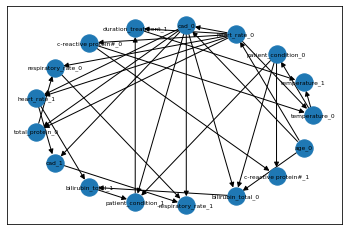

In [17]:
i,j,k,l = make_experiment('duration_treatment', 0.4, 'hc')
gc.collect()

In [18]:
treatment_res = analyze_results('duration_treatment', i, j, k[:-55], l[:-55])
gc.collect()

5159

In [19]:
treatment_res.apply(lambda x: np.round(x, 3))

,precision,recall,F1 score,RMSE,RMAE
test_data,0.959,0.979,0.969,0.144,0.021


In [ ]:
# !zip dbn.zip graphs/outcome.csv graphs/duration_treatment.csv